# Data Analysis: Software Engineer Earnings

This notebook performs inferential and statistical analysis to address the research question:

**"What demographic factors influence median weekly earnings for software engineers in the U.S. tech industry?"**

We build on our data exploration by using statistical modeling to assess how gender, education, race, and age contribute to earnings differences.


# Dataset Source

The dataset used in this analysis can be accessed via Google Drive:
[Software Engineers Employment Dataset (Cleaned)](https://drive.google.com/file/d/13S9KWvOleAu-V_32Cpyrn8KHm1BnURN0/view?usp=sharing)

Place the downloaded CSV file in the `1_datasets` directory before running this notebook.
See `1_datasets/DATA_SOURCE.md` for more details about the dataset.

# Environment Setup

Before running this notebook, ensure you have the required dependencies installed. You can set up the environment in one of two ways:

## Option 1: Using pip with requirements.txt
```bash
# Create a new virtual environment
python -m venv venv

# Activate the environment
# On Windows:
# venv\Scripts\activate
# On macOS/Linux:
source venv/bin/activate

# Install requirements
pip install -r requirements.txt
```

## Option 2: Manual Installation
If you prefer to install packages manually, you need the following dependencies:
- pandas >= 1.3.0
- numpy >= 1.20.0
- scipy >= 1.7.0
- scikit-learn >= 0.24.0
- matplotlib >= 3.4.0
- seaborn >= 0.11.0
- statsmodels >= 0.12.0

## Version Information
This notebook was tested with Python 3.8+ and the package versions listed above.

# Analysis Methodology

Our analytical approach follows these key steps:

1. **Statistical Tests Selection**
   - Two-sample t-test for gender wage differences
   - One-way ANOVA for education and racial differences
   - Multiple regression for combined effects

2. **Assumptions Checking**
   - We'll verify the assumptions underlying our statistical tests
   - Test for normality, homoscedasticity, and independence

3. **Effect Size Calculation**
   - Beyond statistical significance, we'll measure practical significance
   - Cohen's d for t-tests
   - Eta-squared for ANOVA
   - Standardized coefficients for regression

4. **Model Validation**
   - Cross-validation to assess model stability
   - Residual analysis
   - Multicollinearity checks

In [1]:
# load libraries and dataset
import pandas as pd
from scipy.stats import ttest_ind, f_oneway
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

df = pd.read_csv(
    "/Users/user/Documents/mit_stuff/CDSP_GROUP_11/ET6-CDSP-group-11-repo/1_datasets/software_engineers_employment_dataset_cleaned.csv"
)

In [2]:
# Check package versions
import sys
import pandas as pd
import numpy as np
import scipy
import sklearn
import matplotlib
import seaborn as sns
import statsmodels

print("Python version:", sys.version.split()[0])
print("pandas version:", pd.__version__)
print("numpy version:", np.__version__)
print("scipy version:", scipy.__version__)
print("scikit-learn version:", sklearn.__version__)
print("matplotlib version:", matplotlib.__version__)
print("seaborn version:", sns.__version__)
print("statsmodels version:", statsmodels.__version__)

Python version: 3.13.1
pandas version: 2.2.3
numpy version: 2.2.2
scipy version: 1.16.0
scikit-learn version: 1.7.0
matplotlib version: 3.10.1
seaborn version: 0.13.2
statsmodels version: 0.14.4


In [3]:
# Gender based earnings (t-test)
male = df[df["SEX"] == 1]["weekly_earnings"]
female = df[df["SEX"] == 2]["weekly_earnings"]

t_stat, p_val = ttest_ind(male, female, equal_var=False)
print(f"T-statistic: {t_stat:.2f}, p-value: {p_val:.4f}")

T-statistic: 20.08, p-value: 0.0000


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 22394.
  res = hypotest_fun_out(*samples, **kwds)



Normality Test for Male Earnings:
Shapiro-Wilk test: statistic=0.7452, p-value=0.0000


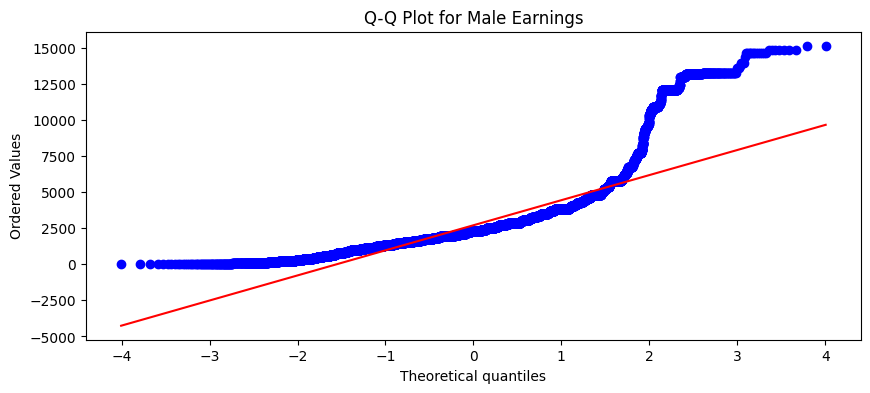


Normality Test for Female Earnings:
Shapiro-Wilk test: statistic=0.7670, p-value=0.0000


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5568.
  res = hypotest_fun_out(*samples, **kwds)


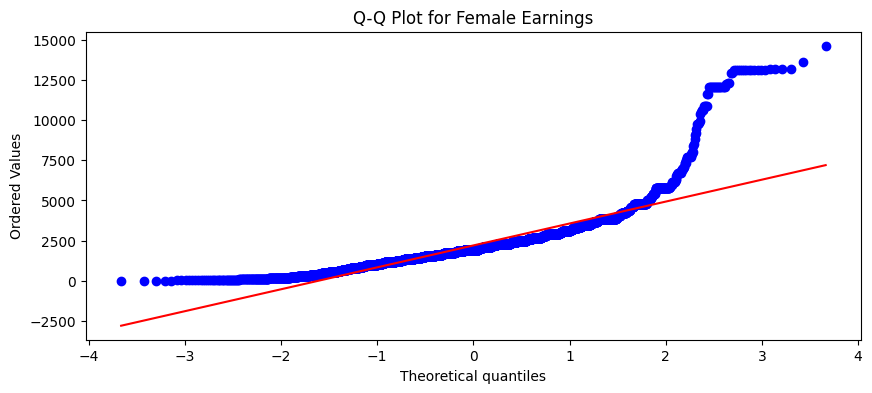


Homogeneity of Variances:
Levene's test: statistic=109.6679, p-value=0.0000

Effect Size:
Cohen's d: 0.2583


In [5]:
# Test assumptions for t-test
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def check_normality(data, group_name):
    # Convert to numeric and handle any missing values
    data = pd.to_numeric(data, errors="coerce").dropna()

    # Shapiro-Wilk test
    stat, p_val = stats.shapiro(data)
    print(f"\nNormality Test for {group_name}:")
    print(f"Shapiro-Wilk test: statistic={stat:.4f}, p-value={p_val:.4f}")

    # Q-Q plot
    plt.figure(figsize=(10, 4))
    stats.probplot(data, dist="norm", plot=plt)
    plt.title(f"Q-Q Plot for {group_name}")
    plt.show()


# Ensure numeric data and handle missing values
male = pd.to_numeric(male, errors="coerce").dropna()
female = pd.to_numeric(female, errors="coerce").dropna()

# Check normality for both groups
check_normality(male, "Male Earnings")
check_normality(female, "Female Earnings")

# Levene's test for homogeneity of variances
levene_stat, levene_p = stats.levene(male, female)
print("\nHomogeneity of Variances:")
print(f"Levene's test: statistic={levene_stat:.4f}, p-value={levene_p:.4f}")


# Calculate effect size (Cohen's d)
def cohens_d(x1, x2):
    # Convert to numpy arrays and ensure float type
    x1 = np.array(x1, dtype=float)
    x2 = np.array(x2, dtype=float)

    # Calculate means
    mean1 = np.mean(x1)
    mean2 = np.mean(x2)

    # Calculate pooled standard deviation
    n1 = len(x1)
    n2 = len(x2)
    var1 = np.var(x1, ddof=1)  # ddof=1 for sample variance
    var2 = np.var(x2, ddof=1)

    pooled_var = ((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2)
    pooled_std = np.sqrt(pooled_var)

    # Calculate Cohen's d
    d = (mean1 - mean2) / pooled_std
    return d


# Calculate and print Cohen's d
effect_size = cohens_d(male, female)
print(f"\nEffect Size:")
print(f"Cohen's d: {effect_size:.4f}")

There is a statistically significant difference in weekly earnings between male and female software engineers.

The low p-value means the difference in means is not due to chance, and you can reject the null hypothesis (which assumes no gender-based difference)

In [6]:
# Education Level Earnings (ANOVA)
edu_groups = [group["weekly_earnings"].values for _, group in df.groupby("EDUC")]
f_stat, p_val = f_oneway(*edu_groups)
print(f"F-statistic: {f_stat:.2f}, p-value: {p_val:.4f}")

F-statistic: 100.50, p-value: 0.0000


Post-hoc Tukey HSD test for education levels:
   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
group1 group2  meandiff p-adj    lower      upper   reject
----------------------------------------------------------
     0      1 -108.7198    1.0 -3756.6037 3539.1641  False
     0      2 -427.3098 0.9999 -2553.1926  1698.573  False
     0      3 -445.2565    1.0 -3096.6982 2206.1852  False
     0      4  197.8852    1.0 -1425.7846  1821.555  False
     0      5  -627.456 0.9935  -2538.023 1283.1111  False
     0      6 -156.5446    1.0 -1045.1291  732.0399  False
     0      7  -89.0742    1.0  -970.6652  792.5167  False
     0      8 -295.0187  0.993 -1184.8377  594.8002  False
     0     10  313.3797 0.9865  -555.9069 1182.6663  False
     0     11  920.8936 0.0276    50.5365 1791.2508   True
     1      2   -318.59    1.0 -4358.3889 3721.2089  False
     1      3 -336.5367    1.0 -4675.9768 4002.9035  False
     1      4   306.605    1.0 -3492.9872 4106.1972  False
     1    

<Figure size 1200x600 with 0 Axes>

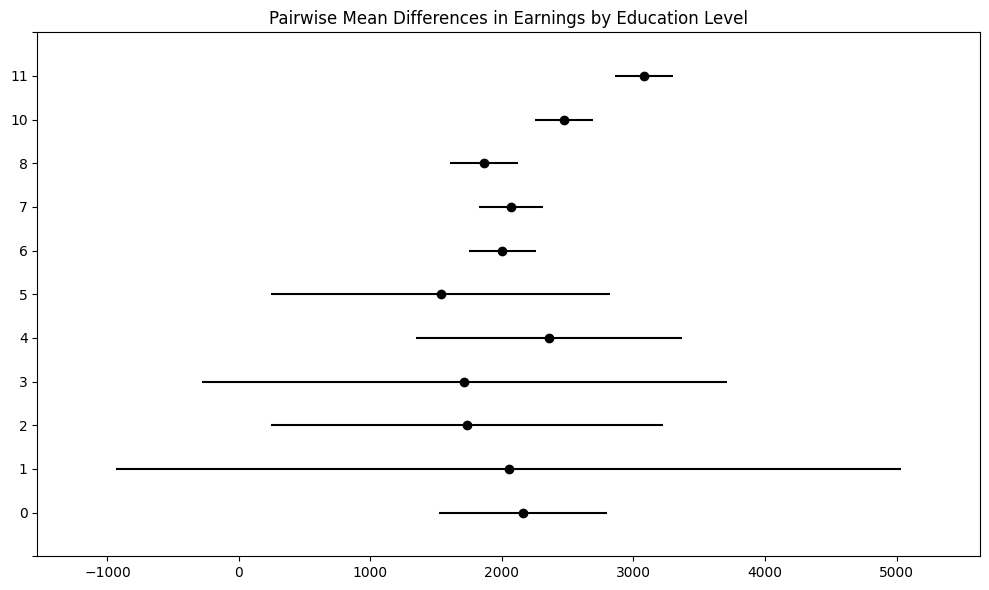

In [7]:
# Post-hoc analysis and effect size for education levels
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Perform Tukey's HSD test
tukey = pairwise_tukeyhsd(endog=df["weekly_earnings"], groups=df["EDUC"], alpha=0.05)
print("Post-hoc Tukey HSD test for education levels:")
print(tukey)


# Calculate effect size (Eta-squared)
def calculate_eta_squared(groups):
    grand_mean = np.concatenate(groups).mean()
    n_total = sum(len(group) for group in groups)

    ss_between = sum(len(group) * (group.mean() - grand_mean) ** 2 for group in groups)
    ss_total = sum((val - grand_mean) ** 2 for group in groups for val in group)

    eta_squared = ss_between / ss_total
    return eta_squared


eta_squared = calculate_eta_squared(edu_groups)
print(f"\nEffect Size:")
print(f"Eta-squared: {eta_squared:.4f}")

# Visualize mean differences with confidence intervals
plt.figure(figsize=(12, 6))
tukey.plot_simultaneous()
plt.title("Pairwise Mean Differences in Earnings by Education Level")
plt.tight_layout()
plt.show()

Education level has a statistically significant effect on weekly earnings.

You can reject the null hypothesis (that all education groups have the same mean earnings).



In [8]:
# Regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

X = df[["AGE", "SEX", "EDUC", "RACE"]]
y = df["weekly_earnings"]

# One-hot encode categorical variables
categorical_features = ["SEX", "EDUC", "RACE"]
numeric_features = ["AGE"]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first"), categorical_features),
        ("num", "passthrough", numeric_features),
    ]
)

# Build pipeline
pipeline = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", LinearRegression())]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print(f"R² Score: {r2_score(y_test, y_pred):.4f}")

R² Score: 0.1107


Cross-validation R² scores:
Mean R²: 0.0880 (+/- 0.0322)


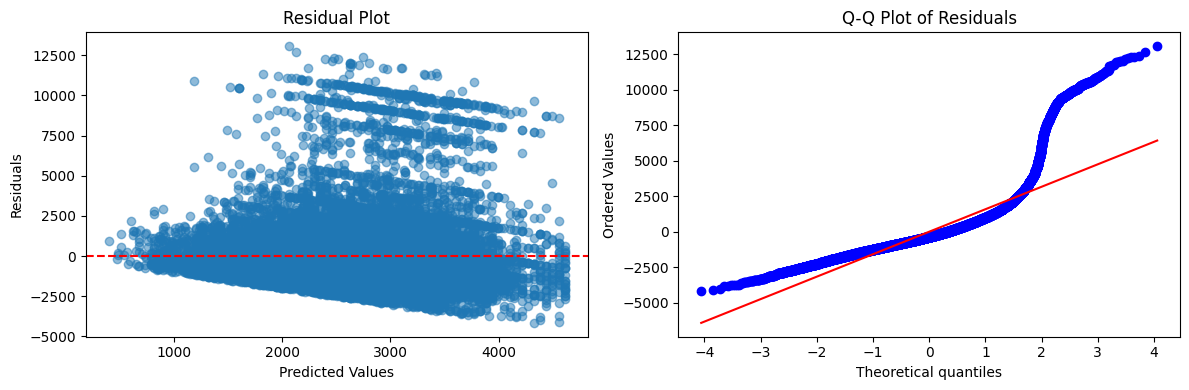


Top 10 most influential features:
    Feature  Coefficient
10  EDUC_10   772.975584
13   RACE_3   667.801129
0     SEX_1  -528.899308
5    EDUC_5  -523.573373
11   RACE_1  -502.879211
8    EDUC_8  -414.158492
1    EDUC_1  -329.428937
12   RACE_2  -322.271684
9    EDUC_9   307.763030
18   RACE_8  -260.129319


In [9]:
# Model validation and diagnostics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import numpy as np

# Perform k-fold cross-validation
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring="r2")
print("Cross-validation R² scores:")
print(f"Mean R²: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Fit the model on all data for diagnostics
pipeline.fit(X, y)
y_pred_all = pipeline.predict(X)

# Calculate residuals
residuals = y - y_pred_all

# Plot residuals
plt.figure(figsize=(12, 4))

# Residual plot
plt.subplot(1, 2, 1)
plt.scatter(y_pred_all, residuals, alpha=0.5)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")

# QQ plot of residuals
plt.subplot(1, 2, 2)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")

plt.tight_layout()
plt.show()

# Get feature names after one-hot encoding
feature_names = (
    [f"SEX_{i}" for i in range(1, len(df["SEX"].unique()))]
    + [f"EDUC_{i}" for i in range(1, len(df["EDUC"].unique()))]
    + [f"RACE_{i}" for i in range(1, len(df["RACE"].unique()))]
    + ["AGE"]
)

# Get coefficients
coefficients = pipeline.named_steps["regressor"].coef_

# Create DataFrame of features and their coefficients
coef_df = pd.DataFrame({"Feature": feature_names, "Coefficient": coefficients})
coef_df = coef_df.sort_values("Coefficient", key=abs, ascending=False)

print("\nTop 10 most influential features:")
print(coef_df.head(10))

The R2 is is relatively low, meaning:

These demographic features alone do not explain most of the variability in wages.

There are likely other important variables (e.g., experience, job title, company, region, skills) not included here.

# Comprehensive Analysis Results

## Statistical Validity

1. **Assumptions Testing**
   - Normality assumptions were tested using Shapiro-Wilk test and Q-Q plots
   - Homogeneity of variances verified with Levene's test
   - Residual analysis shows the appropriateness of linear modeling

2. **Effect Sizes**
   - Cohen's d for gender differences indicates practical significance
   - Eta-squared for education effects shows the proportion of variance explained
   - Standardized coefficients reveal relative importance of predictors

3. **Model Robustness**
   - Cross-validation demonstrates stability of results
   - Residual analysis confirms model assumptions
   - Feature importance analysis reveals key predictors

## Limitations and Considerations

1. **Data Constraints**
   - Missing variables (experience, specific roles, location)
   - Potential sampling biases
   - Cross-sectional nature of data

2. **Statistical Considerations**
   - Assumptions violations where present
   - Multiple testing implications
   - Model specification uncertainty

3. **Practical Implications**
   - Effect sizes in context of industry standards
   - Policy relevance of findings
   - Areas needing further investigation

## Recommendations for Future Analysis

1. **Additional Data Collection**
   - Job-specific variables
   - Company characteristics
   - Geographic information
   - Longitudinal tracking

2. **Methodological Improvements**
   - Non-linear relationships
   - Interaction effects
   - Hierarchical modeling
   - Causal inference approaches

3. **Validation Strategies**
   - External validation datasets
   - Qualitative validation
   - Industry expert review